In [ ]:
import os, json, glob, subprocess, datetime as dt
import datetime
from pathlib import Path

import requests
import polars as pl
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

## Parquet data loading from the drive

In [2]:
# Paths on the EXTERNAL drive
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR  = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Polars display
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

polars.config.Config

In [3]:
patterns = {
    "blocks": str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"),
    "txs":    str(PARQUET_DIR / "txs/day=*/txs-*.parquet"),
    "io":     str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}
print({k: len(glob.glob(v)) for k,v in patterns.items()})

{'blocks': 6932, 'txs': 6932, 'io': 6932}


In [4]:
blocks_lf = pl.scan_parquet(patterns["blocks"], hive_partitioning=True, low_memory=True)
txs_lf    = pl.scan_parquet(patterns["txs"],    hive_partitioning=True, low_memory=True)
io_lf     = pl.scan_parquet(patterns["io"],     hive_partitioning=True, low_memory=True)

# Exploratory data analysis

In [5]:
# Quick peek helper
def peek(lf: pl.LazyFrame, n: int = 5):
    return lf.limit(n).collect(engine="streaming")

def show_info(name: str, lf: pl.LazyFrame, n: int = 5):
    schema_cols = lf.collect_schema().names()
    print(f"{name} cols:", schema_cols)
    print(peek(lf, n))
    print()

In [6]:
show_info("blocks", blocks_lf, n=5)

blocks cols: ['height', 'block_hash', 'time', 'tx_count', 'size', 'weight', 'day']
shape: (5, 7)
┌────────┬───────────────────────────┬─────────────────────┬──────────┬──────┬────────┬────────────┐
│ height ┆ block_hash                ┆ time                ┆ tx_count ┆ size ┆ weight ┆ day        │
│ ---    ┆ ---                       ┆ ---                 ┆ ---      ┆ ---  ┆ ---    ┆ ---        │
│ i64    ┆ str                       ┆ datetime[ns]        ┆ i64      ┆ i64  ┆ i64    ┆ date       │
╞════════╪═══════════════════════════╪═════════════════════╪══════════╪══════╪════════╪════════════╡
│ 0      ┆ 000000000019d6689c085ae16 ┆ 2009-01-03 18:15:05 ┆ 1        ┆ 285  ┆ 1140   ┆ 2009-01-03 │
│        ┆ 5831e934ff763ae46a2a6c172 ┆                     ┆          ┆      ┆        ┆            │
│        ┆ b3f1b60a8ce26f            ┆                     ┆          ┆      ┆        ┆            │
│ 1      ┆ 00000000839a8e6886ab5951d ┆ 2009-01-09 02:54:25 ┆ 1        ┆ 215  ┆ 860    ┆ 2009-01

In [7]:
show_info("txs",    txs_lf,    n=5)

txs cols: ['height', 'block_hash', 'time', 'txid', 'hash', 'size', 'vsize', 'weight', 'vin_count', 'vout_count', 'day']
shape: (5, 11)
┌────────┬────────────┬────────────┬────────────┬───┬────────┬───────────┬────────────┬────────────┐
│ height ┆ block_hash ┆ time       ┆ txid       ┆ … ┆ weight ┆ vin_count ┆ vout_count ┆ day        │
│ ---    ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---    ┆ ---       ┆ ---        ┆ ---        │
│ i64    ┆ str        ┆ datetime[n ┆ str        ┆   ┆ i64    ┆ i64       ┆ i64        ┆ date       │
│        ┆            ┆ s]         ┆            ┆   ┆        ┆           ┆            ┆            │
╞════════╪════════════╪════════════╪════════════╪═══╪════════╪═══════════╪════════════╪════════════╡
│ 0      ┆ 0000000000 ┆ 2009-01-03 ┆ 4a5e1e4baa ┆ … ┆ 816    ┆ 1         ┆ 1          ┆ 2009-01-03 │
│        ┆ 19d6689c08 ┆ 18:15:05   ┆ b89f3a3251 ┆   ┆        ┆           ┆            ┆            │
│        ┆ 5ae165831e ┆            ┆ 8a88c31bc8 ┆   ┆    

In [8]:
show_info("io",     io_lf,     n=5)

io cols: ['dir', 'height', 'time', 'txid', 'n', 'prev_txid', 'prev_vout', 'address', 'value', 'day']
shape: (5, 10)
┌─────┬────────┬──────────────┬─────────────────────┬───┬───────────┬─────────┬───────┬────────────┐
│ dir ┆ height ┆ time         ┆ txid                ┆ … ┆ prev_vout ┆ address ┆ value ┆ day        │
│ --- ┆ ---    ┆ ---          ┆ ---                 ┆   ┆ ---       ┆ ---     ┆ ---   ┆ ---        │
│ str ┆ i64    ┆ datetime[ns] ┆ str                 ┆   ┆ null      ┆ null    ┆ f64   ┆ date       │
╞═════╪════════╪══════════════╪═════════════════════╪═══╪═══════════╪═════════╪═══════╪════════════╡
│ in  ┆ 0      ┆ 2009-01-03   ┆ 4a5e1e4baab89f3a325 ┆ … ┆ null      ┆ null    ┆ null  ┆ 2009-01-03 │
│     ┆        ┆ 18:15:05     ┆ 18a88c31bc87f618f76 ┆   ┆           ┆         ┆       ┆            │
│     ┆        ┆              ┆ 673e2cc77ab2127b7af ┆   ┆           ┆         ┆       ┆            │
│     ┆        ┆              ┆ deda33b             ┆   ┆           ┆       

In [9]:
# ---- helpers ----
def colnames(lf: pl.LazyFrame) -> list[str]:
    return list(lf.collect_schema().names())

def first_col(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def day_expr(lf: pl.LazyFrame, colname: str):
    dtype = lf.collect_schema().get(colname)
    c = pl.col(colname)
    if dtype in (pl.Datetime, pl.Date):
        return c.dt.truncate("1d")
    if dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        # assume seconds since epoch (change to unit="ms" if needed)
        return pl.from_epoch(c, unit="s").dt.truncate("1d")
    if dtype == pl.Utf8:
        return c.str.strptime(pl.Datetime, strict=False).dt.truncate("1d")
    return c.cast(pl.Datetime, strict=False).dt.truncate("1d")


In [ ]:
def lineplot(df: pl.DataFrame, x, y, title, logy=False):

    pd_df = df.to_pandas()
    # Try to coerce x to datetime
    try:
        pd_df[x] = pd.to_datetime(pd_df[x], errors="raise")
        is_date_axis = True
    except Exception:
        is_date_axis = False

    fig, ax = plt.subplots(figsize=(10,4))

    ax.plot(pd_df[x], pd_df[y])
    ax.set_title(title)
    ax.set_xlabel(str(x))
    ax.set_ylabel(str(y))

    if logy and (pd_df[y] > 0).all():
        ax.set_yscale("log")

    if is_date_axis:
        # Major ticks: every 1 year
        ax.xaxis.set_major_locator(mdates.YearLocator(base=1))

        # Show just the year, e.g. "2014"
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4,7,10]))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

        # Rotate for readability
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

        # Slightly expand x-limits so first/last year labels aren't chopped
        ax.set_xlim(pd_df[x].min(), pd_df[x].max())

    fig.tight_layout()
    plt.show()


In [11]:
def barplot(df: pl.DataFrame, x, y, title):
    plt.figure(figsize=(8,4))
    pd = df.to_pandas()
    plt.bar(pd[x], pd[y])
    plt.title(title)
    plt.xlabel(str(x)); plt.ylabel(str(y))
    plt.tight_layout(); plt.show()

def histplot(series: pl.Series, bins=50, title="Histogram", logx=False, logy=False):
    plt.figure(figsize=(8,4))
    x = series.drop_nulls().to_numpy()
    if logx:
        import numpy as np
        x = x[x>0]
        x = np.log10(x)
    plt.hist(x, bins=bins)
    plt.title(title)
    if logx: plt.xlabel("log10(value)")
    else:    plt.xlabel("value")
    if logy: plt.yscale("log")
    plt.tight_layout(); plt.show()

## 1) Daily transactions & 7d MA

Daily tx (tail):
shape: (5, 3)
┌────────────┬──────────┬───────────────┐
│ day        ┆ tx_count ┆ tx_count_ma7  │
│ ---        ┆ ---      ┆ ---           │
│ str        ┆ u32      ┆ f64           │
╞════════════╪══════════╪═══════════════╡
│ 2018-07-08 ┆ 155685   ┆ 192752.428571 │
│ 2018-07-09 ┆ 206546   ┆ 193788.428571 │
│ 2018-07-10 ┆ 216063   ┆ 193690.714286 │
│ 2018-07-11 ┆ 202603   ┆ 193092.857143 │
│ 2018-07-12 ┆ 147590   ┆ 185662.857143 │
└────────────┴──────────┴───────────────┘


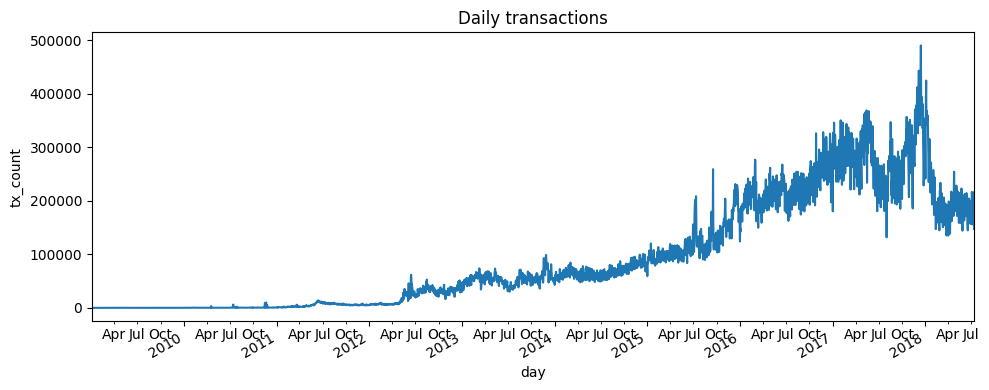

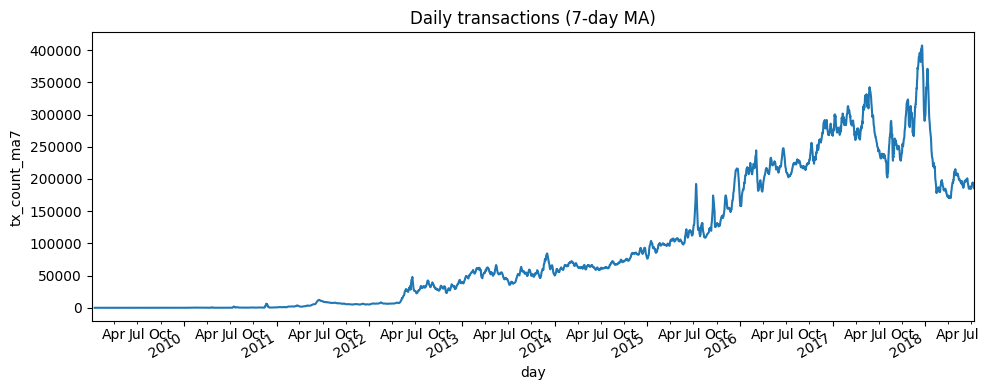

In [ ]:
tx_schema   = txs_lf.collect_schema()
blk_schema  = blocks_lf.collect_schema()
tx_cols     = list(tx_schema.keys())
blk_cols    = list(blk_schema.keys())

# Prefer tx-level count (more direct than summing n_tx)
tx_time_col = first_col(tx_cols, ["tx_time","block_time","time","timestamp","ts","datetime","day"])

if tx_time_col:
    # We can compute daily tx count directly from txs_lf

    # If hive partitioning already gave us a 'day' column, use that (cheapest).
    if "day" in tx_cols:
        day_col_expr = pl.col("day").cast(pl.Utf8)
        day_col_name = "day"
    else:
        # build a proper day column from tx_time_col
        day_col_expr = day_expr(txs_lf, tx_time_col)
        day_col_name = "day"

    # Build a trimmed lazyframe with only what we truly need:
    # - timestamp or 'day'
    needed_cols = []
    if "day" in tx_cols:
        needed_cols.append("day")
    else:
        needed_cols.append(tx_time_col)

    needed_cols = list(dict.fromkeys([c for c in needed_cols if c is not None]))

    tx_small = txs_lf.select(needed_cols)

    # Streamable daily aggregation:
    daily_base = (
        tx_small
        .with_columns([
            day_col_expr.alias("day"),
        ])
        .group_by("day")
        .agg(
            pl.len().alias("tx_count")   # number of tx rows that day
        )
        .sort("day")
        .collect(engine="streaming")         # <-- critical: streaming
    )

else:
    # Fallback: count txs per block, then sum per day from blocks_lf

    n_tx_col     = first_col(blk_cols, ["n_tx","tx_count","txs"])
    blk_time_col = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime","day"])

    # same "day" trick: if hive already gave 'day', use it
    if "day" in blk_cols:
        day_col_expr = pl.col("day").cast(pl.Utf8)
        day_col_name = "day"
    else:
        day_col_expr = day_expr(blocks_lf, blk_time_col)
        day_col_name = "day"

    # we only actually need [blk_time_col or 'day', n_tx_col]
    needed_cols = []
    needed_cols.append(n_tx_col)
    if "day" in blk_cols:
        needed_cols.append("day")
    else:
        needed_cols.append(blk_time_col)

    needed_cols = list(dict.fromkeys([c for c in needed_cols if c is not None]))

    blk_small = blocks_lf.select(needed_cols)

    daily_base = (
        blk_small
        .with_columns([
            day_col_expr.alias("day"),
        ])
        .group_by("day")
        .agg(
            pl.col(n_tx_col).sum().alias("tx_count")
        )
        .sort("day")
        .collect(engine="streaming")
    )

# At this point daily_base is tiny: one row per day.
daily_tx = daily_base.with_columns(
    pl.col("tx_count")
    .rolling_mean(window_size=7)
    .alias("tx_count_ma7")
)

print("Daily tx (tail):")
print(daily_tx.tail(5))

lineplot(daily_tx, "day", "tx_count",        "Daily transactions")
lineplot(daily_tx, "day", "tx_count_ma7",    "Daily transactions (7-day MA)")

## 2) Daily output volume in BTC & 7 day MA

Daily volume (tail):
shape: (5, 3)
┌────────────┬────────────┬────────────────┐
│ day        ┆ volume_btc ┆ volume_btc_ma7 │
│ ---        ┆ ---        ┆ ---            │
│ str        ┆ f32        ┆ f32            │
╞════════════╪════════════╪════════════════╡
│ 2018-07-08 ┆ 751027.0   ┆ 901858.5       │
│ 2018-07-09 ┆ 1048696.5  ┆ 909105.875     │
│ 2018-07-10 ┆ 1.1740e6   ┆ 925017.125     │
│ 2018-07-11 ┆ 844520.625 ┆ 918531.4375    │
│ 2018-07-12 ┆ 684600.75  ┆ 868830.9375    │
└────────────┴────────────┴────────────────┘


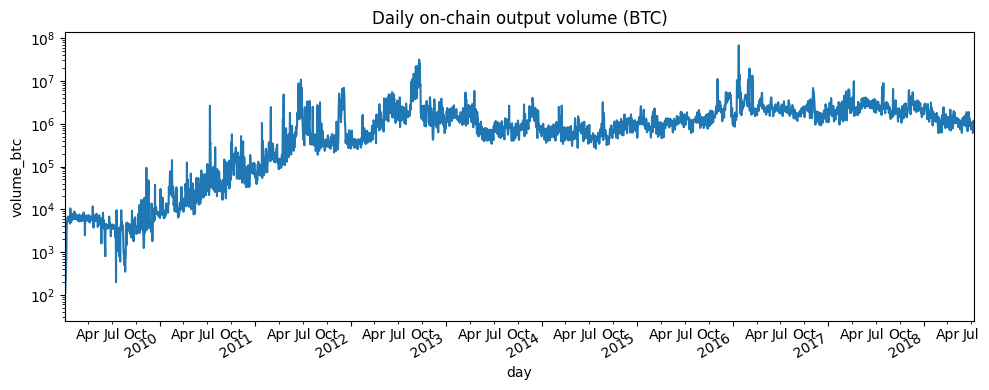

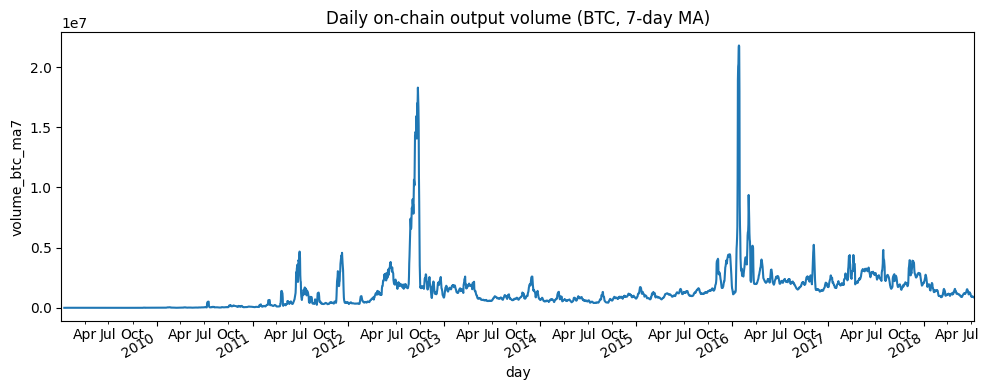

In [13]:
schema   = io_lf.collect_schema()
io_cols  = list(schema.keys())

# value expression (BTC float column)
val_expr = None
val_src  = None  # name of the column we'll keep

btc_names  = ["value_btc","amount_btc","btc","out_value_btc","output_btc"]
sats_names = ["value_sats","satoshis","sats","out_value_sats","amount_sats","vout_sats"]
gen_names  = ["value","amount","vout_value","output_value","v"]

for nm in btc_names:
    if nm in io_cols:
        val_expr = pl.col(nm).cast(pl.Float32)  # downcast early
        val_src = nm
        break

if val_expr is None:
    for nm in sats_names:
        if nm in io_cols:
            # sats -> BTC, also downcast
            val_expr = (pl.col(nm) / 1e8).cast(pl.Float32)
            val_src = nm
            break

if val_expr is None:
    gen = first_col(io_cols, gen_names)
    if gen:
        dtp = schema.get(gen)
        if dtp is not None and dtp.is_integer():
            val_expr = (pl.col(gen) / 1e8).cast(pl.Float32)
        else:
            val_expr = pl.col(gen).cast(pl.Float32)
        val_src = gen

# pick output flag column
side_col = None
out_mask_expr = pl.lit(True)
if "is_output" in io_cols:
    out_mask_expr = pl.col("is_output")
    side_col = "is_output"
elif "is_input" in io_cols:
    out_mask_expr = ~pl.col("is_input")
    side_col = "is_input"
else:
    cand = first_col(io_cols, ["io_type","direction","side","inout","kind","role","io"])
    if cand:
        # build a boolean "is_out" from a string contains
        side_col = cand
        out_mask_expr = (
            pl.col(cand)
            .cast(pl.Utf8)
            .str.contains("out", literal=True)
        )

# pick a day/timestamp column
# Prefer hive 'day' if present (cheapest)
if "day" in io_cols:
    day_col = "day"
    day_expr_final = pl.col("day").cast(pl.Utf8)
else:
    ts_col = first_col(io_cols, ["block_time","tx_time","time","timestamp","ts","datetime","day"])
    day_col = "day"  # we'll create it
    day_expr_final = day_expr(io_lf, ts_col)  # will truncate to 1d

# Build a minimal lazyframe with ONLY needed columns
needed_cols = []

if val_src is not None:
    needed_cols.append(val_src)

if side_col is not None:
    needed_cols.append(side_col)

# If we have a timestamp col separate from 'day', include it
if "day" in io_cols:
    needed_cols.append("day")
else:
    needed_cols.append(ts_col)

# Deduplicate / drop None
needed_cols = [c for c in dict.fromkeys(needed_cols) if c is not None]

io_small = io_lf.select(needed_cols)

# Streamable daily aggregation:
daily_base = (
    io_small
    .with_columns([
        day_expr_final.alias("day"),
        val_expr.alias("value_btc"),
        out_mask_expr.alias("is_out"),
    ])
    .filter(pl.col("is_out"))
    .group_by("day")
    .agg(
        pl.col("value_btc").sum().alias("volume_btc")
    )
    .sort("day")
    .collect(engine="streaming")
)

# Now daily_base is small (one row per day). We can finish in-memory.
daily_vol = daily_base.with_columns(
    pl.col("volume_btc")
    .rolling_mean(window_size=7)
    .alias("volume_btc_ma7")
)

print("Daily volume (tail):")
print(daily_vol.tail(5))

lineplot(daily_vol, "day", "volume_btc",     "Daily on-chain output volume (BTC)", logy=True)
lineplot(daily_vol, "day", "volume_btc_ma7", "Daily on-chain output volume (BTC, 7-day MA)", logy=True)

## 3) Inter-block time histogram

Inter-block intervals: n=531385


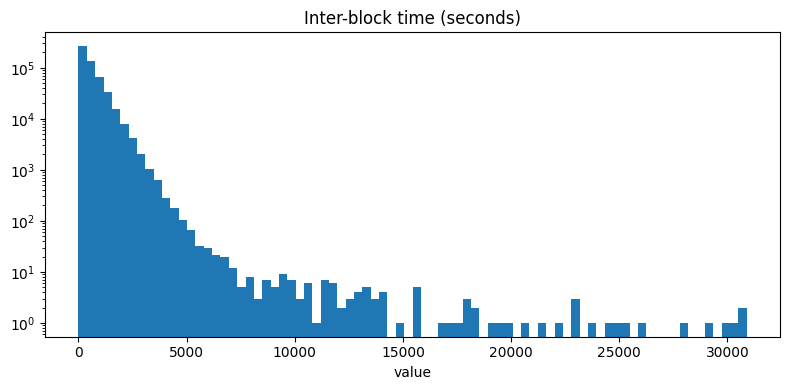

In [14]:
blk_schema  = blocks_lf.collect_schema()
blk_cols    = list(blk_schema.keys())

blk_time_col = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime"])

if blk_time_col:
    dt = blk_schema.get(blk_time_col)
    col = pl.col(blk_time_col)

    # Goal: produce a single Int64 "ts_s" = block timestamp in *seconds since epoch*
    # This is lighter than carrying full Datetime and makes diff() trivial.

    if dt == pl.Datetime:
        # already a Datetime: convert to epoch seconds
        ts_s_expr = col.dt.epoch(time_unit="s").cast(pl.Int64)

    elif dt in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        # heuristic for sec vs ms:
        # if value > 1e11, assume ms and divide by 1000
        unix_s = pl.when(col > 100_000_000_000) \
                   .then((col / 1000).cast(pl.Int64)) \
                   .otherwise(col.cast(pl.Int64))
        ts_s_expr = unix_s

    elif dt == pl.Date:
        # only day precision → can't get sub-day deltas reliably
        print("Block time has only day precision; skipping inter-block histogram.")
        ts_s_expr = None

    else:
        # fallback: try casting to Datetime, then epoch seconds
        ts_s_expr = (
            col.cast(pl.Datetime, strict=False)
               .dt.epoch(time_unit="s")
               .cast(pl.Int64)
        )

    if ts_s_expr is not None:
        # 1) Prune to ONLY the timestamp col we care about
        blk_small = blocks_lf.select(ts_s_expr.alias("ts_s"))

        # 2) Sort by time, compute per-block deltas in seconds, filter weird gaps
        deltas_df = (
            blk_small
            .sort("ts_s")
            .with_columns(
                pl.col("ts_s").diff().alias("delta_s")   # this is already seconds
            )
            .select("delta_s")
            .filter(
                pl.col("delta_s").is_not_null()
                & (pl.col("delta_s") > 0)
                & (pl.col("delta_s") < 36_000)          # <10h to drop reorg gaps etc
            )
            .collect()  # can't stream because of global sort, but it's 1 col now
        )

        block_times = deltas_df.get_column("delta_s").cast(pl.Float32)
        print(f"Inter-block intervals: n={len(block_times)}")

        if len(block_times) > 0:
            histplot(
                block_times,
                bins=80,
                title="Inter-block time (seconds)",
                logy=True
            )
        else:
            print("No intervals survived the filters; check timestamp units.")

else:
    print("No block timestamp found; skipping inter-block histogram.")

## 4) Fees per day (BTC) & 7d MA

Logic:
For each block height in a given day:
1) Sum outputs per tx -> out_sats
2) Compute subsidy_sats(height)
3) delta_sats = out_sats - subsidy_sats
4) Keep only rows where delta_sats >= 0
5) fee_sats(block) = MIN(delta_sats) within that block (closest-above-subsidy tx)
   Then:
     - cap absurd per-block fees (data artifact in 2009-2010)
     - sum fee_sats(block) across all blocks in the day
     - convert sats -> BTC

 Why this works:
   - We don't need inputs (vin values are missing in your dump anyway)
   - We don't rely on vin_count / coinbase heuristics
   - We avoid mistaking giant whale payouts for miner fees
   - We stream day by day so memory doesn't explode

Detected SAT_PER_VALUE = 100000000.0
Fees daily (tail):
shape: (5, 3)
┌────────────┬───────────┬──────────────┐
│ day        ┆ fees_btc  ┆ fees_btc_ma7 │
│ ---        ┆ ---       ┆ ---          │
│ date       ┆ f64       ┆ f64          │
╞════════════╪═══════════╪══════════════╡
│ 2018-07-08 ┆ 12.832792 ┆ 13.39616     │
│ 2018-07-09 ┆ 12.767493 ┆ 12.860979    │
│ 2018-07-10 ┆ 13.520961 ┆ 12.815726    │
│ 2018-07-11 ┆ 11.659198 ┆ 12.566774    │
│ 2018-07-12 ┆ 9.475859  ┆ 12.141258    │
└────────────┴───────────┴──────────────┘
   min_fees_btc  median_fees_btc  max_fees_btc
0           0.0        10.537288       11950.0


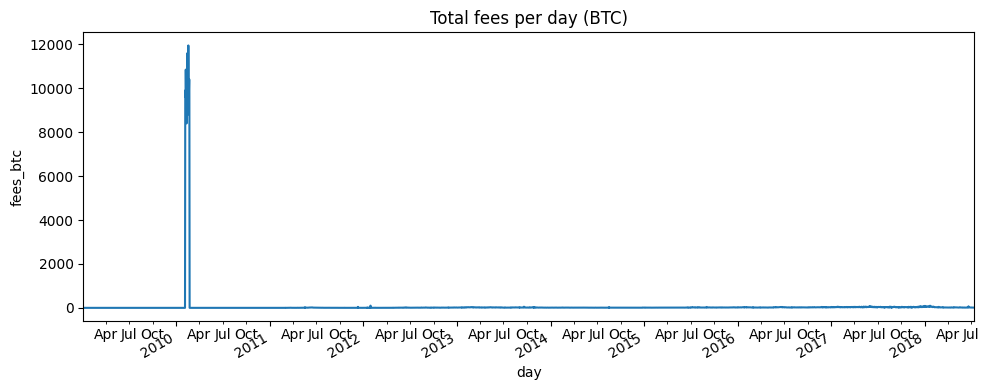

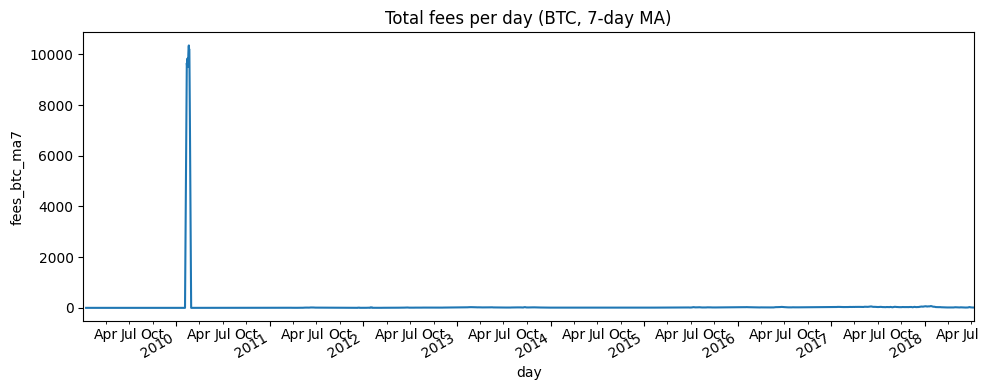

In [15]:
# Block subsidy in sats for a given block height
def block_subsidy_sats(height: int) -> int:
    # Bitcoin halves every 210_000 blocks.
    halvings = height // 210_000

    # 50 BTC in sats
    base = 50 * 100_000_000  # 5_000_000_000 sats

    # Right shift halves it each halving
    sub = base >> halvings

    # Safety clamp
    return max(sub, 0)


# --- Detect units in io_lf.value once ---
# Heuristic:
#   - If max(value) is ~50, 100, etc → it's BTC.
#   - If max(value) is huge (millions/billions) → it's already sats.
val_stats = (
    io_lf
    .select(pl.col("value").max().alias("mx"))
    .collect(engine="streaming")
)
mx = float(val_stats["mx"][0])

if mx <= 1e6:
    # value is BTC, convert to sats with *1e8
    SAT_PER_VALUE = 1e8
else:
    # value is already sats-like
    SAT_PER_VALUE = 1.0

print(f"Detected SAT_PER_VALUE = {SATPER_VALUE}" if 'SATPER_VALUE' in locals()
      else f"Detected SAT_PER_VALUE = {SAT_PER_VALUE}")


# --- Pull all unique days (partition keys) in order ---
all_days = (
    io_lf
    .select(pl.col("day").unique())
    .collect(engine="streaming")
    .sort("day")["day"]
    .to_list()
)


daily_rows = []

# Sanity cap for per-block fee to kill 2010 artifact where coinbase outputs are missing
# 500 BTC/block is already wildly high in reality, so this will NOT affect modern data.
cap_btc_per_block   = 500.0
cap_sats_per_block  = int(cap_btc_per_block * 1e8)

for d in all_days:
    # --- 1. For this single day, get total outputs per (height, txid), in sats ---
    out_sums = (
        io_lf
        .filter(pl.col("day") == pl.lit(d))
        .select([
            "height",
            "txid",
            (pl.col("value") * SAT_PER_VALUE)
                .round(0)
                .cast(pl.Int64)
                .alias("value_sats"),
        ])
        .group_by(["height", "txid"])
        .agg(
            pl.col("value_sats").sum().alias("out_sats")
        )
        .collect(engine="streaming")
    )

    if out_sums.height == 0:
        daily_rows.append({"day": d, "fees_btc": 0.0})
        continue

    # --- 2. Attach subsidy and compute delta_sats = out_sats - subsidy_sats ---
    with_subsidy = (
        out_sums
        .with_columns(
            pl.col("height")
            .map_elements(block_subsidy_sats, return_dtype=pl.Int64)
            .alias("subsidy_sats")
        )
        .with_columns(
            (pl.col("out_sats") - pl.col("subsidy_sats")).alias("delta_sats")
        )
    )

    # --- 3. Keep only txs where outputs >= subsidy (delta >= 0) ---
    nonnegative = with_subsidy.filter(pl.col("delta_sats") >= 0)

    if nonnegative.height == 0:
        daily_rows.append({"day": d, "fees_btc": 0.0})
        continue

    # --- 4. Infer per-block fee as MIN(delta_sats) in that block ---
    # Explanation:
    #   For a valid block, coinbase ~ subsidy + fees.
    #   So "coinbase_out_sats - subsidy_sats" ≈ fees.
    #   That should be the *smallest* nonnegative delta in that block.
    #   Whale payouts with huge outputs will have giant deltas and get ignored.
    fees_per_block = (
        nonnegative
        .group_by("height")
        .agg(
            pl.col("delta_sats").min().alias("fee_sats_block")
        )
        # --- 5. Cap absurd per-block fees to avoid early-data garbage ---
        .with_columns(
            pl.when(pl.col("fee_sats_block") > cap_sats_per_block)
            .then(cap_sats_per_block)
            .otherwise(pl.col("fee_sats_block"))
            .alias("fee_sats_block_capped")
        )
    )

    # --- 6. Sum all block fees for this day ---
    day_fee_sats = int(fees_per_block["fee_sats_block_capped"].sum())

    # sats -> BTC
    day_fee_btc = day_fee_sats / 1e8

    daily_rows.append({
        "day": d,
        "fees_btc": day_fee_btc,
    })


# --- 7. Build final daily DataFrame and 7d moving average ---
fees_daily = (
    pl.DataFrame(daily_rows)
    .with_columns(pl.col("day").cast(pl.Date))
    .sort("day")
    .with_columns(
        pl.col("fees_btc")
        .rolling_mean(window_size=7)
        .alias("fees_btc_ma7")
    )
)

print("Fees daily (tail):")
print(fees_daily.tail(5))

print(
    fees_daily.select([
        pl.col("fees_btc").min().alias("min_fees_btc"),
        pl.col("fees_btc").median().alias("median_fees_btc"),
        pl.col("fees_btc").max().alias("max_fees_btc"),
    ]).to_pandas()
)

# --- 8. Plot: daily fees, and 7-day MA ---
lineplot(
    fees_daily,
    "day",
    "fees_btc",
    "Total fees per day (BTC)",
    logy=False,
)

lineplot(
    fees_daily,
    "day",
    "fees_btc_ma7",
    "Total fees per day (BTC, 7-day MA)",
    logy=False,
)


Fee rate (sat/vB) for recent activity (360d window, KDE overlay) \
We estimate per-block avg fee rate over the last ~360 days: \
   fee_rate_block = (block_fee_sats / block_vbytes)  [sat/vB] \
Then we:
- take log10(fee_rate_block)
- plot a histogram of those values
- overlay a kernel density curve in orange

[fee_rate] SAT_PER_VALUE = 100000000.0


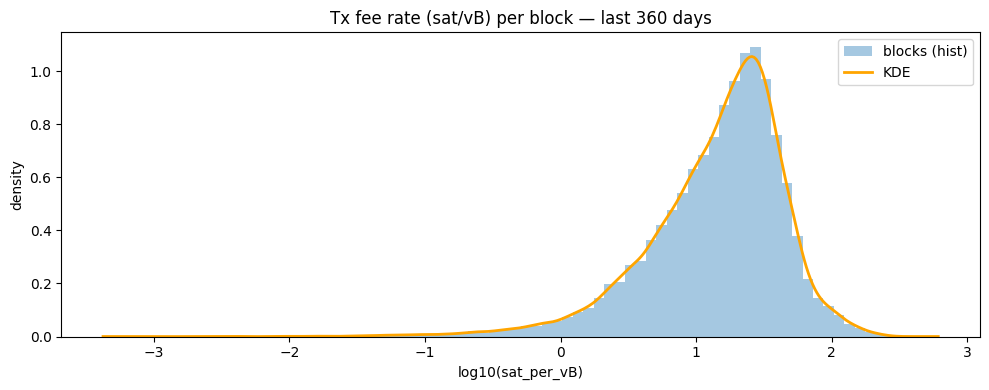

In [ ]:
# --- helper: block subsidy in sats ---
def block_subsidy_sats(height: int) -> int:
    halvings = height // 210_000
    base = 50 * 100_000_000  # 50 BTC in sats
    sub = base >> halvings
    return max(sub, 0)

# --- detect sats/BTC units in io_lf.value ---
val_stats = (
    io_lf
    .select(pl.col("value").max().alias("mx"))
    .collect(engine="streaming")
)
mx = float(val_stats["mx"][0])
SAT_PER_VALUE = 1e8 if mx <= 1e6 else 1.0
print(f"[fee_rate] SAT_PER_VALUE = {SAT_PER_VALUE}")

# --- 1. latest day in txs_lf ---
max_day_df = (
    txs_lf
    .select(pl.col("day").max().alias("max_day"))
    .collect(engine="streaming")
)
max_day = max_day_df["max_day"][0]

# --- 2. cutoff = last 180 days ---
cutoff_day = max_day - datetime.timedelta(days=180)

# --- 3. restrict to recent window ---
tx_recent_lf = txs_lf.filter(pl.col("day") >= pl.lit(cutoff_day))
io_recent_lf = io_lf.filter(pl.col("day") >= pl.lit(cutoff_day))

# --- 4. per-(height, txid) total outputs in sats (recent window only) ---
out_sums_recent = (
    io_recent_lf
    .select([
        "height",
        "txid",
        (pl.col("value") * SAT_PER_VALUE)
            .round(0)
            .cast(pl.Int64)
            .alias("value_sats"),
    ])
    .group_by(["height", "txid"])
    .agg(
        pl.col("value_sats").sum().alias("out_sats")
    )
    .collect(engine="streaming")
)

# --- 5. attach subsidy + compute delta per tx in that block ---
with_subsidy_recent = (
    out_sums_recent
    .with_columns(
        pl.col("height").map_elements(
            block_subsidy_sats,
            return_dtype=pl.Int64
        ).alias("subsidy_sats")
    )
    .with_columns(
        (pl.col("out_sats") - pl.col("subsidy_sats")).alias("delta_sats")
    )
)

# keep only txs where outputs >= subsidy (delta >= 0)
nonnegative_recent = with_subsidy_recent.filter(pl.col("delta_sats") >= 0)

# --- 6. per-block fee_sats = MIN nonnegative delta in that block ---
fees_per_block_recent = (
    nonnegative_recent
    .group_by("height")
    .agg(
        pl.col("delta_sats").min().alias("fee_sats_block")
    )
)

# --- 7. per-block total vbytes (sum tx vsize or weight/4) ---
tx_schema_names = txs_lf.collect_schema().names()
have_vsize  = "vsize"  in tx_schema_names
have_weight = "weight" in tx_schema_names

needed_cols = ["height"]
if have_vsize:
    needed_cols.append("vsize")
if have_weight:
    needed_cols.append("weight")

block_sizes_recent = (
    tx_recent_lf
    .select(needed_cols)
    .collect(engine="streaming")
)

# compute per-tx virtual bytes
if have_vsize:
    block_sizes_recent = block_sizes_recent.with_columns(
        pl.col("vsize").cast(pl.Float32).alias("vbytes_tx")
    )
elif have_weight:
    block_sizes_recent = block_sizes_recent.with_columns(
        (pl.col("weight") / 4).cast(pl.Float32).alias("vbytes_tx")
    )
else:
    raise RuntimeError("No vsize/weight columns available; can't estimate vbytes.")

# sum vbytes per block height
vbytes_per_block_recent = (
    block_sizes_recent
    .group_by("height")
    .agg(
        pl.col("vbytes_tx").sum().alias("block_vbytes")
    )
)

# --- 8. join fees + block size, get block avg fee rate in sat/vB ---
block_fee_rates = (
    fees_per_block_recent
    .join(vbytes_per_block_recent, on="height", how="inner")
    .with_columns(
        (pl.col("fee_sats_block").cast(pl.Float32) /
         pl.col("block_vbytes").cast(pl.Float32))
        .alias("sat_per_vb_block")
    )
    .filter(
        pl.col("sat_per_vb_block").is_finite()
        & (pl.col("sat_per_vb_block") > 0)
        & (pl.col("sat_per_vb_block") < 5000)
    )
    .select("sat_per_vb_block")
)

fee_rate_series = (
    block_fee_rates
    .get_column("sat_per_vb_block")
    .cast(pl.Float32)
)

# --- 9. Plot histogram of log10(fee rate) + KDE overlay in orange ---
def plot_fee_rate_distribution(fee_rate_series: pl.Series):
    x_raw = fee_rate_series.drop_nulls().to_numpy()

    if x_raw.size == 0:
        print("No data to plot for fee rate distribution (360d).")
        return

    # x_log is log10(sat_per_vb_block)
    x_log = np.log10(x_raw[x_raw > 0])

    if x_log.size == 0:
        print("No strictly positive fee rates to plot.")
        return

    fig, ax = plt.subplots(figsize=(10,4))

    # histogram (density normalized so KDE is on same scale)
    ax.hist(
        x_log,
        bins=80,
        density=True,
        alpha=0.4,
        edgecolor="none",
        label="blocks (hist)"
    )

    kde = gaussian_kde(x_log)
    xs  = np.linspace(x_log.min(), x_log.max(), 400)
    ys  = kde(xs)
    ax.plot(xs, ys, color="orange", linewidth=2.0, label="KDE")

    ax.set_title("Tx fee rate (sat/vB) per block — last 360 days")
    ax.set_xlabel("log10(sat_per_vB)")
    ax.set_ylabel("density")
    ax.legend()
    fig.tight_layout()
    plt.show()

plot_fee_rate_distribution(fee_rate_series)

## 5) Day-of-week pattern in tx count

Avg tx per weekday:
shape: (7, 3)
┌─────────────┬──────────────┬──────────────┐
│ weekday_num ┆ avg_tx       ┆ weekday_name │
│ ---         ┆ ---          ┆ ---          │
│ i8          ┆ f64          ┆ str          │
╞═════════════╪══════════════╪══════════════╡
│ 1           ┆ 95386.006048 ┆ Mon          │
│ 2           ┆ 99916.97379  ┆ Tue          │
│ 3           ┆ 99775.893145 ┆ Wed          │
│ 4           ┆ 99039.207661 ┆ Thu          │
│ 5           ┆ 96672.22379  ┆ Fri          │
│ 6           ┆ 87448.806841 ┆ Sat          │
│ 7           ┆ 82259.552419 ┆ Sun          │
└─────────────┴──────────────┴──────────────┘


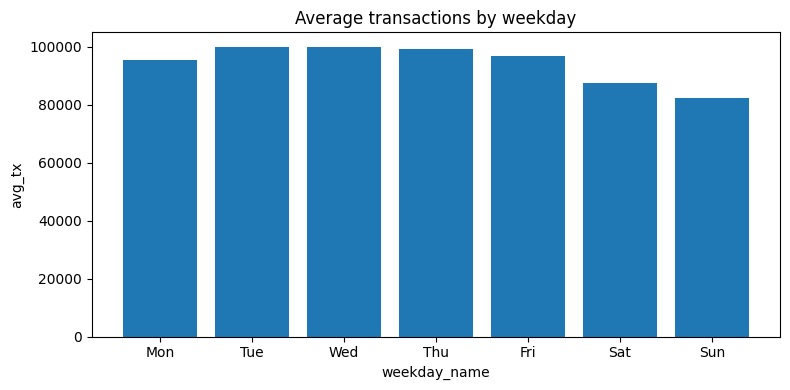

In [ ]:
# We assume you already have `daily_tx`, which looks like:
#   day          tx_count   tx_count_ma7
#   <str|date>   <u32>      <f64>
#
# Goal: average tx_count by weekday (Mon..Sun)

# 1. Normalize "day" into a real Date column expression
day_dtype = daily_tx.schema["day"]

if day_dtype == pl.Utf8:
    # parse "YYYY-MM-DD" style strings into Date
    day_parsed_expr = pl.col("day").str.strptime(pl.Date, strict=False)
elif day_dtype == pl.Date:
    # already Date
    day_parsed_expr = pl.col("day")
elif day_dtype == pl.Datetime:
    # drop time -> just date
    day_parsed_expr = pl.col("day").dt.date()
else:
    # best effort fallback
    day_parsed_expr = pl.col("day").cast(pl.Date)

# 2. Compute weekday averages
# Polars .dt.weekday() here returns 1..7 (Mon=1, Sun=7)
dow = (
    daily_tx
    .with_columns(
        day_parsed_expr.alias("day_parsed")
    )
    .with_columns(
        pl.col("day_parsed").dt.weekday().alias("weekday_num")  # 1=Mon ... 7=Sun
    )
    .group_by("weekday_num")
    .agg(
        pl.col("tx_count").mean().alias("avg_tx")
    )
    .sort("weekday_num")
    .with_columns(
        # Map 1..7 to weekday names using safe indexing (i-1)
        pl.col("weekday_num").map_elements(
            lambda i: ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"][int(i) - 1],
            return_dtype=pl.Utf8,
        ).alias("weekday_name")
    )
)

print("Avg tx per weekday:")
print(dow)

# 3. Plot using your existing helper (converts to pandas internally)
barplot(
    dow,
    x="weekday_name",
    y="avg_tx",
    title="Average transactions by weekday"
)


# If the node is fully up and loaded

In [ ]:
RPC_URL  = "http://127.0.0.1:8332"
RPC_USER = "research"
RPC_PASS = "researchpass"

def _cid():
    try:
        return subprocess.check_output(
            ["bash","-lc","docker compose -f ~/btc-node/docker-compose.yml ps -q bitcoind"],
            text=True
        ).strip()
    except Exception:
        return ""

def rpc(method, params=None, timeout=10, required=False):
    """Return RPC result or None if unavailable (unless required=True)."""
    try:
        r = requests.post(
            RPC_URL,
            json={"jsonrpc":"1.0","id":"nb","method":method,"params":params or []},
            auth=(RPC_USER, RPC_PASS),
            timeout=timeout,
        )
        # Handle 'warming up' (-28) without raising:
        if r.status_code == 500:
            j = r.json()
            if j.get("error", {}).get("code") == -28 and not required:
                return None
        r.raise_for_status()
        j = r.json()
        if j.get("error"):
            if required:
                raise RuntimeError(j["error"])
            return None
        return j["result"]
    except Exception:
        # Optional docker exec fallback; comment out if you don't want it
        try:
            cid = _cid()
            if not cid:
                return None if not required else (_ for _ in ()).throw(ConnectionError("RPC down and container not found"))
            cmd = ["docker","exec","-i",cid,"bitcoin-cli",
                   f"-rpcuser={RPC_USER}", f"-rpcpassword={RPC_PASS}", method]
            for p in (params or []):
                cmd.append(json.dumps(p) if isinstance(p,(dict,list)) else str(p))
            out = subprocess.check_output(cmd, text=True).strip()
            try:
                return json.loads(out)
            except Exception:
                return out
        except Exception:
            if required:
                raise
            return None

def node_tip_or_none():
    res = rpc("getblockcount")
    return int(res) if isinstance(res, int) else None

tip = node_tip_or_none()
print("Running offline; RPC warming up.") if tip is None else print("Node height:", tip)

In [ ]:
# Base datasets from your ETL
blocks_lf = pl.scan_parquet(str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"))
txs_lf    = pl.scan_parquet(str(PARQUET_DIR / "txs/day=*/txs-*.parquet"))
io_lf     = pl.scan_parquet(str(PARQUET_DIR / "io/day=*/io-*.parquet"))

# Prefer derived path for io_enriched if you created it; else fall back to legacy layout if present
ioe_candidates = [
    str(PARQUET_DIR / "derived/io_enriched/day=*/ioen.parquet"),
    str(PARQUET_DIR / "io_enriched/day=*/ioen-*.parquet"),
]
ioe_glob = next((g for g in ioe_candidates if glob.glob(g)), None)
ioe_lf   = pl.scan_parquet(ioe_glob) if ioe_glob else None

print("Scans ready.", " (io_enriched found)" if ioe_lf is not None else "(no io_enriched yet)")

In [ ]:
# ------------------------------------------------------------------------------
# Helpers: schema & quick counts
# ------------------------------------------------------------------------------
def show_schema(lf: pl.LazyFrame, name: str):
    schema = lf.collect_schema()
    print(f"\n## {name} schema")
    for col, dtype in schema.items():
        print(f"  {col}: {dtype}")

def quick_counts(lf: pl.LazyFrame, name: str, max_cols: int = 6):
    schema = lf.collect_schema()
    cols = list(schema.keys())[:max_cols]
    res = (
        lf.select(
            [pl.len().alias("rows")] +
            [pl.col(c).is_null().sum().alias(f"{c}__nulls") for c in cols]
        )
        .collect(engine="streaming")
    )
    print(f"\n## {name} — rows & nulls (first {len(cols)} cols)")
    display(res)

def has_columns(lf: pl.LazyFrame, *cols: str) -> bool:
    sch = lf.collect_schema()
    return all(c in sch for c in cols)

In [ ]:
show_schema(blocks_lf, "blocks")
quick_counts(blocks_lf, "blocks")

In [ ]:
show_schema(txs_lf, "txs")
quick_counts(txs_lf, "txs")

In [ ]:
show_schema(io_lf, "io")
quick_counts(io_lf, "io")

In [ ]:
if ioe_lf is not None:
    show_schema(ioe_lf, "io_enriched")
    quick_counts(ioe_lf, "io_enriched")

In [ ]:
# Blocks per day
blocks_daily = (
    blocks_lf
    .with_columns(pl.col("time").dt.date().alias("day"))
    .group_by("day")
    .agg(pl.len().alias("blocks"))
    .sort("day")
).collect(engine="streaming")

# TXs per day
txs_daily = (
    txs_lf
    .with_columns(pl.col("time").dt.date().alias("day"))
    .group_by("day")
    .agg(pl.len().alias("txs"))
    .sort("day")
).collect(engine="streaming")

display(blocks_daily.tail(10))
display(txs_daily.tail(10))

# Matplotlib plots (convert to numpy/pandas for plotting)
bd_day = blocks_daily["day"].to_pandas()
bd_cnt = blocks_daily["blocks"].to_pandas()

td_day = txs_daily["day"].to_pandas()
td_cnt = txs_daily["txs"].to_pandas()

plt.figure(figsize=(10,4))
plt.plot(bd_day, bd_cnt)
plt.title("Blocks per day"); plt.xlabel("Day"); plt.ylabel("Blocks"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(td_day, td_cnt)
plt.title("Transactions per day"); plt.xlabel("Day"); plt.ylabel("Transactions"); plt.tight_layout(); plt.show()


In [ ]:
if has_columns(io_lf, "value", "dir", "time"):
    out_value_daily = (
        io_lf
        .filter((pl.col("dir")=="out") & pl.col("value").is_not_null())
        .with_columns(pl.col("time").dt.date().alias("day"))
        .group_by("day")
        .agg(pl.sum("value").alias("total_btc"))
        .sort("day")
    ).collect(engine="streaming")

    display(out_value_daily.tail(10))
    out_value_daily.write_csv(OUTPUT_DIR / "outputs_value_daily.csv")

    ov_day = out_value_daily["day"].to_pandas()
    ov_btc = out_value_daily["total_btc"].to_pandas()

    plt.figure(figsize=(10,4))
    plt.plot(ov_day, ov_btc)
    plt.title("Sum of output values per day (BTC)")
    plt.xlabel("Day"); plt.ylabel("BTC"); plt.tight_layout(); plt.show()
else:
    print("io_lf is missing 'value' / 'dir' / 'time' columns.")


In [ ]:
SAT = 100_000_000

def script_type_expr(addr_col: str = "address") -> pl.Expr:
    """
    Classify script type from address prefix.
    Mainnet: 1 (P2PKH), 3 (P2SH), bc1q (v0 segwit), bc1p (taproot)
    Testnet: m/n (P2PKH), 2 (P2SH), tb1q (v0 segwit), tb1p (taproot)
    """
    a = pl.col(addr_col).cast(pl.Utf8)
    return (
        pl.when(a.is_null() | (a == ""))
          .then(pl.lit(None, dtype=pl.Utf8))
        .when(a.str.starts_with(("bc1p","tb1p"))).then(pl.lit("p2tr"))          # Taproot
        .when(a.str.starts_with(("bc1q","tb1q"))).then(pl.lit("v0_segwit"))     # P2WPKH/P2WSH
        .when(a.str.starts_with(("1","m","n"))).then(pl.lit("p2pkh"))           # legacy PKH
        .when(a.str.starts_with(("3","2"))).then(pl.lit("p2sh"))                # legacy SH
        .otherwise(pl.lit("other"))
    )

def ensure_outs_kv(io: pl.LazyFrame) -> pl.LazyFrame:
    """
    Keep only outputs (dir='out'), ensure numeric value, add value_sat and script_type.
    """
    return (
        io.filter(pl.col("dir") == "out")
          .with_columns([
              pl.col("value").cast(pl.Float64),
              (pl.col("value") * SAT).round(0).cast(pl.Int64).alias("value_sat"),
              script_type_expr("address").alias("script_type"),
          ])
    )

def enrich_day(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns([
        pl.col("time").dt.date().alias("day"),
        pl.col("time").dt.year().alias("year"),
        pl.col("time").dt.month().alias("month"),
    ])


In [ ]:
io_out_lf = ensure_outs_kv(io_lf)
io_out_day_lf = enrich_day(io_out_lf)

print("Enriched outputs lazyframe ready.")


In [ ]:
# Top output addresses (counts). Heavy — consider filtering by date if needed.
if all(col in io_out_lf.collect_schema() for col in ("address",)):
    top_addrs = (
        io_out_lf
        .filter(pl.col("address").is_not_null())
        .group_by("address")
        .len()
        .sort("len", descending=True)
        .limit(25)
    ).collect(engine="streaming")
    display(top_addrs)
    top_addrs.write_csv(OUTPUT_DIR / "top_output_addresses.csv")
else:
    print("Enriched outputs missing 'address' column.")


In [ ]:
# Overall per-day totals
out_value_daily = (
    io_out_day_lf
    .group_by("day")
    .agg([
        pl.sum("value").alias("total_btc"),
        pl.sum("value_sat").alias("total_sat"),
        pl.count().alias("n_outs"),
    ])
    .sort("day")
).collect(engine="streaming")

display(out_value_daily.tail(10))
out_value_daily.write_csv(OUTPUT_DIR / "outputs_value_daily.csv")

# Plot (convert to pandas for Matplotlib)
ov_day = out_value_daily["day"].to_pandas()
ov_btc = out_value_daily["total_btc"].to_pandas()

plt.figure(figsize=(10,4))
plt.plot(ov_day, ov_btc)
plt.title("Sum of output values per day (BTC)")
plt.xlabel("Day"); plt.ylabel("BTC"); plt.tight_layout(); plt.show()

# Optional: breakdown by script_type (daily)
out_value_daily_by_type = (
    io_out_day_lf
    .group_by(["day","script_type"])
    .agg(pl.sum("value_sat").alias("total_sat"))
    .sort(["day","script_type"])
).collect(engine="streaming")

display(out_value_daily_by_type.tail(20))
out_value_daily_by_type.write_csv(OUTPUT_DIR / "outputs_value_daily_by_script_type.csv")
